# **RECOMMENDER SYSTEM**

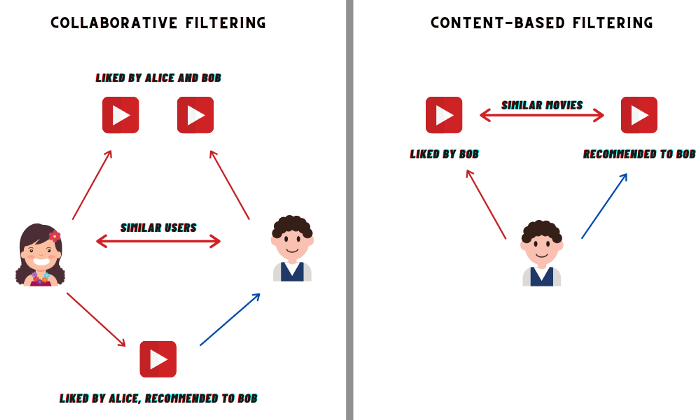


1. **Recommender system Collaborative Filtering** sering disebut **Recommender system User-User**, karena melihat kemiripan antara satu user (misal: userA) dengan user lainnya. Apabila sudah ditemukan user mana saja yg mirip dengan userA, maka sistem akan memberikan rekomendasi produk yg disukai dan dibeli oleh user-user yg mirip dengan userA

- *Users who are similar to you also like..*
- *Recommendations for you*

2. **Recommender system Content-Based Filtering** sering disebut **Recommender system Item-Item**, karena melihat kemiripan antara satu produk (misal: produkA) yg sedang dicari atau dilihat user dengan produk lainnya. Apabila sudah ditemukan produk mana saja yang mirip dengan produkA, maka sistem akan memberikan rekomendasi produk yg mirip dengan produkA

- *Similar products*
- *You may also like..*

# **Recommender System User-User**

## Code

In [ ]:
def recommender_user_for(user_A):
    # Import Package
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import random
    import re
    %matplotlib inline
    sns.set_style('white')
    sns.set()
    import warnings
    warnings.filterwarnings("ignore")

    # Data
    df = pd.read_csv('data_ikan.csv')
    df['Item_id'] = range(1,len(df)+1)
    df = df.rename(columns={'Nama':'Title', 'Harga':'Price','Terjual': 'Num of Rate'})
    df = df[['Item_id','Title', 'Penjual', 'Price', 'Num of Rate']]
    df['Price'] = [float(i)*1000 for i in df['Price']]
    df['Num of Rate'] = [int(i) for i in df['Num of Rate']]

    # Cleaning title
    df['Title'] = [i.lower() for i in df['Title']]
    df_title = []
    for i in df['Title']:
        ikan = re.findall(r"ikan\s\D+", i)
        for number in range(len(ikan)):
            if number == 0:
                df_title.append(ikan[number])
    df = df[:len(df_title)].copy()
    df['Title'] = df_title
    df['Title'] = [i.capitalize() for i in df['Title']]
    df_title_penjual = []
    for index, i in enumerate(df['Title']):
        i = i+f' ({df["Penjual"][index]})'
        df_title_penjual.append(i)
    df['Title'] = df_title_penjual
    df = df[['Item_id','Title', 'Price', 'Num of Rate']]

    # Data user history (dummy)
    random.seed(12)
    all_user = []
    all_rating = []
    all_item = []
    num_rate_all = 0
    for index, item in enumerate(df['Item_id']):
        num_rate = df['Num of Rate'][index]
        num_rate_all += num_rate
        for i in range(num_rate):
            user_id = random.randint(1, 100)
            # distribusi num of rate untuk setiap nilai rating
            if num_rate_all <= (df['Num of Rate'].values.sum()/5):
                rating = random.randint(1,5)
            elif num_rate_all <= ((2*df['Num of Rate'].values.sum())/5):
                rating = random.randint(3,4)
            elif num_rate_all <= ((3*df['Num of Rate'].values.sum())/5):
                rating = random.randint(4,5)
            else:
                rating = random.randint(4,5)
            all_user.append(user_id)
            all_rating.append(rating)
            all_item.append(item)
    user_history = pd.DataFrame(all_user, columns=['User_id'])
    user_history['Item_id'] = all_item
    user_history['Rating'] = all_rating

    # dictionary of username with its id (dummy data)
    username = ['andhika19', 'nisannin22','anindya19','fasyaarnetta','divasafitra3','don18001','ferdiansy','galuh1800','insaan200','iqbal1900','ivan20','jacobsitumeang05',
    'jajang170','jevon21','muhammad2','matni2000','nafila180','nashella1','ainifathiyyahnurul','rahmat170','ramaulinap','ratna1800','raudya31','renata543','rizki2','rosalyna2',
    'salma2001','shiva2000','sulistian','swito1800','syaira200','syifa1902','tasya2000','utari2000','wahyu2000','abiy20001','azalia200','azka20004','dhiwa2000','dias20001',
    'fanisyarani','farrah200','fildza200','gabryella','gena20001','josua2000','krisna200','denis2','muhammad1','nabillamhrn27','naila2000','nisa18004','nur20007','najma007',
    'qaulan190','rahmatani','raisya180','regina200','regina200','risya1800','sulthan18','timothea1','trie18001','zahra1800','adella200','adlan1700','dicky170','ahmad1701',
    'aldya1800','alexander','alifia170','alinda190','aliya2000','alkaina19','almanda20','rozi180','ananda190','anandayuliantidewi','andreas19','ardelia19','ariella18','arif19003',
    'arrayyan1','ashila200','atang2000','azzahra19','bebie.tho','billy1800','cindy2000','dandy1800','denashya1','devy19002','dheandra1','dedit1','diana2000','doohan190',
    'elda19001','elizabeth','elvia1700','fathianni']

    user_name_id = {}
    for i in range(100):
        user_name_id[username[i]] = i

    # Data ikan title
    ikan_title = df[['Item_id', 'Title', 'Price']].copy()

    # Data clean
    data = user_history.merge(ikan_title, on='Item_id')

    # DATA PIVOT TABLE

    fishmat = data.pivot_table(index='User_id', columns='Title', values='Rating')
    # fill 0 in NaN values
    fishmat = fishmat.fillna(0)

    # turn pivot table into dataframe
    fishmat = pd.DataFrame(fishmat)
    # Reset index
    fishmat = fishmat.reset_index(drop=True)

    # normalization function
    def normalization(dataframe):
        dataframe_mean = dataframe.mean(axis=1)
        return dataframe.subtract(dataframe_mean, axis = 'rows')

    # apply to data
    norm_fishmat = normalization(fishmat)

    # function to find similarity person
    def similarity_pearson(x, y):
        import scipy.stats
        return scipy.stats.pearsonr(x, y)[0]
    
    # apply method
    similarity_matrix = np.array([similarity_pearson(fishmat.iloc[i,:], fishmat.iloc[j,:])
                                  for i in range(100) for j in range(100)])

    similarity_df = pd.DataFrame(similarity_matrix.reshape(100,100))

    # user-name or user-id
    if type(user_A) == str:
        user_A = user_name_id[user_A]

    # Find similar neighbors using the threshold method.
    def neighbours(sim):
        idx_neighbours = []
        for i in range(len(sim)):
            if similarity_df_drop.iloc[i,user_A]>=0.3:  # klo similarity > 0.3
                idx_neighbours.append(similarity_df_drop.index[i])
        return idx_neighbours
    
    # drop active users
    similarity_df_drop = similarity_df.copy()
    similarity_df_drop = similarity_df_drop.drop([user_A])

    # select rating product by similar user
    neighbor_fishmat = norm_fishmat.loc[neighbours(similarity_df_drop)]

    # select similarity values between user active and similar user
    neighbor_similarity = similarity_df[user_A].loc[neighbours(similarity_df_drop)]

    # select items and the score for recommendation
    def score_item(neighbor_fishmat, neighbor_similarity, fishmat):
        # aumr -> active user mean rating
        aumr = np.mean(fishmat.iloc[user_A, :])
        score = np.dot(neighbor_similarity, neighbor_fishmat) + aumr
        data = score.reshape(1, len(score))
        columns = neighbor_fishmat.columns
        return pd.DataFrame(data = data , columns = columns)
    
    # find the score of all items
    score_item_user = score_item(neighbor_fishmat, neighbor_similarity, fishmat)

    # find 5 products recommended
    name_product_recommended = []
    score_product_recommended = []

    for (score, index) in sorted( [(score,index) for (index,score) in enumerate(score_item_user.iloc[0])], reverse=True )[:5]:
        name_product_recommended.append(score_item_user.columns[index])
        score_product_recommended.append(score)

    product_recommended = pd.DataFrame(score_product_recommended, columns=['Score'])
    product_recommended.index = name_product_recommended

    if user_A%2 == 0:
        print('Users who are similar to you also liked:')
    else:
        print('Recommendations for you:')
    return product_recommended

## List User

**List user yang ada di ecommerce kami:**

**(user_name, user_id)**

In [ ]:
# dummy data

username = ['andhika19', 'nisannin22','anindya19','fasyaarnetta','divasafitra3','don18001','ferdiansy','galuh1800','insaan200','iqbal1900','ivan20','jacobsitumeang05',
    'jajang170','jevon21','muhammad2','matni2000','nafila180','nashella1','ainifathiyyahnurul','rahmat170','ramaulinap','ratna1800','raudya31','renata543','rizki2','rosalyna2',
    'salma2001','shiva2000','sulistian','swito1800','syaira200','syifa1902','tasya2000','utari2000','wahyu2000','abiy20001','azalia200','azka20004','dhiwa2000','dias20001',
    'fanisyarani','farrah200','fildza200','gabryella','gena20001','josua2000','krisna200','denis2','muhammad1','nabillamhrn27','naila2000','nisa18004','nur20007','najma007',
    'qaulan190','rahmatani','raisya180','regina200','regina200','risya1800','sulthan18','timothea1','trie18001','zahra1800','adella200','adlan1700','dicky170','ahmad1701',
    'aldya1800','alexander','alifia170','alinda190','aliya2000','alkaina19','almanda20','rozi180','ananda190','anandayuliantidewi','andreas19','ardelia19','ariella18','arif19003',
    'arrayyan1','ashila200','atang2000','azzahra19','bebie.tho','billy1800','cindy2000','dandy1800','denashya1','devy19002','dheandra1','dedit1','diana2000','doohan190',
    'elda19001','elizabeth','elvia1700','fathianni']

user_name_id = {}
for i in range(100):
    user_name_id[username[i]] = i

import operator
sorted(user_name_id.items(), key=operator.itemgetter(1))

[('andhika19', 0),
 ('nisannin22', 1),
 ('anindya19', 2),
 ('fasyaarnetta', 3),
 ('divasafitra3', 4),
 ('don18001', 5),
 ('ferdiansy', 6),
 ('galuh1800', 7),
 ('insaan200', 8),
 ('iqbal1900', 9),
 ('ivan20', 10),
 ('jacobsitumeang05', 11),
 ('jajang170', 12),
 ('jevon21', 13),
 ('muhammad2', 14),
 ('matni2000', 15),
 ('nafila180', 16),
 ('nashella1', 17),
 ('ainifathiyyahnurul', 18),
 ('rahmat170', 19),
 ('ramaulinap', 20),
 ('ratna1800', 21),
 ('raudya31', 22),
 ('renata543', 23),
 ('rizki2', 24),
 ('rosalyna2', 25),
 ('salma2001', 26),
 ('shiva2000', 27),
 ('sulistian', 28),
 ('swito1800', 29),
 ('syaira200', 30),
 ('syifa1902', 31),
 ('tasya2000', 32),
 ('utari2000', 33),
 ('wahyu2000', 34),
 ('abiy20001', 35),
 ('azalia200', 36),
 ('azka20004', 37),
 ('dhiwa2000', 38),
 ('dias20001', 39),
 ('fanisyarani', 40),
 ('farrah200', 41),
 ('fildza200', 42),
 ('gabryella', 43),
 ('gena20001', 44),
 ('josua2000', 45),
 ('krisna200', 46),
 ('denis2', 47),
 ('muhammad1', 48),
 ('nabillamhrn27'

## Hasil

**Dapat diisi dengan user_id, ataupun user_name.**

**Bisa berupa recommend *'Users who are similar to you also liked:'* bisa juga *'Recommendations for you:'*. Keduanya sama.**

In [ ]:
recommender_user_for(2)

Users who are similar to you also liked:


,Score
Ikan kembung banjar premium lokal segar dan bergaransi / pack (iita.bee),8.480407
Ikan dory / dori / patin (pangaseus) white/bl beku per pack (ibumart_bekasi),7.567329
Ikan pink danio zebra (flyfarm.id),7.072776
Ikan baronang standar lokal segar dan bergaransi / pack (linda.hakim),7.067772
Ikan mujaer segar (rafa_aquascape),6.528426


In [ ]:
recommender_user_for(51)

In [ ]:
recommender_user_for('najma007')

Recommendations for you:


,Score
Ikan pari asap / iwak pe (triofrozenciwastra),5.351873
Ikan kakap giling super (rifkyaryanto),4.885590
Ikan gabus fillet (hy.shop),4.742641
Ikan kembung banjar premium lokal segar dan bergaransi / pack (iita.bee),4.731761
Ikan platy micky mouse hias (22seafoodamt),3.665262


In [ ]:
recommender_user_for('denis2')

Recommendations for you:


,Score
Ikan tongkol/ hasil laut/ seafood (oishiseafood),12.796840
Ikan kakap giling super (rifkyaryanto),11.614377
Ikan platy micky mouse hias (22seafoodamt),11.101767
Ikan louhan f (dynakh),9.776569
Ikan tongkol (goedangjamdjakarta),9.024697


## **Recommender System Item-Item**

## Code

In [ ]:
def recommender_item_for(product_A):
    # Import Packages
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import random
    import re
    %matplotlib inline
    sns.set_style('white')
    sns.set()
    pd.set_option('display.max_rows', None)
    import warnings
    warnings.filterwarnings("ignore")

    # data
    df = pd.read_csv('data_ikan.csv')
    df['Item_id'] = range(1,len(df)+1)
    df = df.rename(columns={'Nama':'Title', 'Harga':'Price','Terjual': 'Num of Rate'})
    df = df[['Item_id','Title', 'Penjual', 'Price', 'Num of Rate']]
    df['Price'] = [float(i)*1000 for i in df['Price']]
    df['Num of Rate'] = [int(i) for i in df['Num of Rate']]

    # Cleaning title
    df['Title'] = [i.lower() for i in df['Title']]
    df_title = []
    for i in df['Title']:
        ikan = re.findall(r"ikan\s\D+", i)
        for number in range(len(ikan)):
            if number == 0:
                df_title.append(ikan[number])
    df = df[:len(df_title)].copy()
    df['Title'] = df_title
    df['Title'] = [i.capitalize() for i in df['Title']]
    df_title_penjual = []
    for index, i in enumerate(df['Title']):
        i = i+f' ({df["Penjual"][index]})'
        df_title_penjual.append(i)

    df['Title'] = df_title_penjual
    df = df[['Item_id','Title', 'Price', 'Num of Rate']]

    # Data user history (dummy)
    random.seed(12)
    all_user = []
    all_rating = []
    all_item = []
    num_rate_all = 0
    for index, item in enumerate(df['Item_id']):
        num_rate = df['Num of Rate'][index]
        num_rate_all += num_rate
        for i in range(num_rate):
            user_id = random.randint(1, 100)
            # distribusi num of rate untuk setiap nilai rating
            if num_rate_all <= (df['Num of Rate'].values.sum()/5):
                rating = random.randint(1,5)
            elif num_rate_all <= ((2*df['Num of Rate'].values.sum())/5):
                rating = random.randint(3,4)
            elif num_rate_all <= ((3*df['Num of Rate'].values.sum())/5):
                rating = random.randint(4,5)
            else:
                rating = random.randint(4,5)
            all_user.append(user_id)
            all_rating.append(rating)
            all_item.append(item)
    user_history = pd.DataFrame(all_user, columns=['User_id'])
    user_history['Item_id'] = all_item
    user_history['Rating'] = all_rating

    # Data ikan title
    ikan_title = df[['Item_id', 'Title', 'Price']].copy()

    # Data clean
    data = user_history.merge(ikan_title, on='Item_id')

    # rata-rata rating untuk setiap item
    rating = data.groupby('Title')['Rating'].mean()

    # number of rating untuk setiap item
    rating_count = data.groupby('Title')['Rating'].count()

    # rata-rata price untuk setiap item
    price = data.groupby('Title')['Price'].mean()

    # dataframe of rating
    df_rating = pd.DataFrame(rating)
    df_rating['num_of_rate'] = rating_count
    df_rating['Price'] = price

    # Pivot table
    fishmat = data.pivot_table(index='User_id', columns='Title', values='Rating')

    # Rating produk_A
    A_rating = fishmat[product_A]

    # produk yg memiliki korelasi tinggi dgn produk A
    similar_to_A = fishmat.corrwith(A_rating)

    # create dataframe
    corr_A = pd.DataFrame(similar_to_A, columns=['Correlation'])
    corr_A.dropna(inplace=True)
    # join number of rate each title
    corr_A = corr_A.join([df_rating['num_of_rate'], df_rating['Rating'], df_rating['Price']])

    # filter with num of rate > 50
    corr_A = corr_A[corr_A['num_of_rate'] > 50]
    
    random = np.random.randint(1,3)
    if random == 1:
        print('Similar products:')
    else:
        print('You may also like:')
    return corr_A.sort_values(by='Correlation', ascending=False)[1:6]

## List Ikan

In [ ]:
import pandas as pd
import re

df = pd.read_csv('data_ikan.csv')
df['Item_id'] = range(1,len(df)+1)
df = df.rename(columns={'Nama':'Title', 'Harga':'Price','Terjual': 'Num of Rate'})
df = df[['Item_id','Title', 'Penjual', 'Price', 'Num of Rate']]
df['Price'] = [float(i)*1000 for i in df['Price']]
df['Num of Rate'] = [int(i) for i in df['Num of Rate']]

# Cleaning title
df['Title'] = [i.lower() for i in df['Title']]
df_title = []
for i in df['Title']:
    ikan = re.findall(r"ikan\s\D+", i)
    for number in range(len(ikan)):
        if number == 0:
            df_title.append(ikan[number])
df = df[:len(df_title)].copy()
df['Title'] = df_title
df['Title'] = [i.capitalize() for i in df['Title']]
df_title_penjual = []
for index, i in enumerate(df['Title']):
    i = i+f' ({df["Penjual"][index]})'
    df_title_penjual.append(i)

df['Title'] = df_title_penjual
df['Title'].unique()

array(['Ikan kembung banjar - kembung gepeng segar  (serba.ikan.pamulang)',
       'Ikan bawal laut segar (serbaikanfresh)',
       'Ikan dori fillet lokal / ikan dori restoran / fish n chips @ (dapurlaut)',
       'Ikan tongkol cakalang segar (sip) (serba.ikan.pamulang)',
       'Ikan belanak segar  (seafood_wike)',
       'Ikan gembung banjar beku fresh -  (inaranahl)',
       'Ikan gembung  (cherilstore)',
       'Ikan nila merah segar fresh  (abangsayur.id)',
       'Ikan kembung banjar fresh (hy.shop)',
       'Ikan segar gurame segar fresh  (seenamart)',
       'Ikan shisamo frozen  (sibasfishfactory)',
       'Ikan kembung banjar -  (riniard)',
       'Ikan gindara fillet steak  (blisskitchenid)',
       'Ikan betok /papuyu konsumsi (sentralikansawahjakarta)',
       'Ikan sebelah air tawar pemakan bakteri jahat dalam pasir dan lumut (bahteraaquarium)',
       'Ikan kaca piring rejung kaca  (packikan_store)',
       'Ikan bawal putih kualitas ekspor (cahayabahari89)',
       'Ik

## Hasil

In [ ]:
recommender_item_for('Ikan pink danio zebra (flyfarm.id)')

Similar products:


,Correlation,num_of_rate,Rating,Price
Title,,,,
Ikan kembung banjar (sarahfadilla.kontak),0.349428,78,4.435897,80000.0
Ikan dori fillet (zulfiero),0.302087,69,4.434783,45000.0
Ikan kembung banjar premium lokal segar dan bergaransi / pack (iita.bee),0.276121,88,4.500000,23000.0
Ikan bawal putih kualitas ekspor (cahayabahari89),0.268489,58,3.431034,27000.0
Ikan pink danio zebra (22seafoodamt),0.240656,58,4.517241,42000.0


In [ ]:
recommender_item_for('Ikan manfish albino red eye (kitabeef08)')

Similar products:


,Correlation,num_of_rate,Rating,Price
Title,,,,
Ikan kembung fresh (marisa.riana),0.432450,76,3.552632,28000.0
Ikan dori ikan patin fillet lokal @ (rizexo),0.401449,56,4.428571,6400.0
Ikan mahi mahi fillet (22seafoodamt),0.358017,54,3.481481,35000.0
Ikan bawal putih kualitas ekspor (agenroajakarta),0.330435,59,4.677966,100000.0
Ikan guppy albino sky red (rajadagingtgr),0.268635,63,4.539683,38000.0


In [ ]:
recommender_item_for('Ikan kakap merah  (jalaikan)')